In [1]:
import EigensetReader
import torch 
import torch.nn as nn 
import torch.nn.functional as f
import tensorflow as tf
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt 
import auto_encoder2d
import random

In [2]:
data_2x2 = EigensetReader.Eigenset()
data_2x2.read("results2.eigenset") 
print(data_2x2.numberEigenvectors)
print(np.sum(np.array(data_2x2.eigenpairs[0].Eigenvector) ** 2))

# _y = np.empty(shape=(250500,16))
# for i in range(0, 250500):
#     x = data_2x2.eigenpairs[i].Eigenvector
#     _y[i]=x

250500
1.0000000000000004


In [3]:
print(data_2x2.eigenpairs[250499].J)
print(data_2x2.eigenpairs[250499].Bx)
print(data_2x2.eigenpairs[100].Bz)

data = auto_encoder2d.get_dataset(data_2x2, 2, 250500)        
training_data, val_data = random_split(data, [200000,50500])
training_loader = DataLoader(training_data, batch_size = 50,  shuffle=True, num_workers=6)

1.0
2.997
2.6


In [4]:
warmup = next(iter(training_loader))

In [5]:
mps_size = 5
model = auto_encoder2d.MPS_autoencoder2d(mps_size = mps_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss(reduction='sum')
warmup_2 = (warmup,2)
for j in range(10):
    for epoch in range(10):
        fields,wf = warmup
        gs = model(fields, warmup_2[1])            
        loss = loss_func(gs, warmup_2[1])
        if (epoch % 10 == 0):
            print(loss.item() *(2**4))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

AttributeError: 'int' object has no attribute 'size'

In [ ]:
for j in range(10):
    print("Cycle: \t", j)
    print("*"*40)
    for epoch in range(201):
        fields,wf = warmup
        gs = model(fields, 2)            
        loss = loss_func(gs, wf)
        if (epoch % 100 == 0):
            print(loss.item()*(16))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

(1000, 16)
[ 1.   0.5  0.5  0.   0.5  0.   0.  -0.5  0.5  0.   0.  -0.5  0.  -0.5
 -0.5 -1. ]


Text(0, 0.5, 'Magnetization')

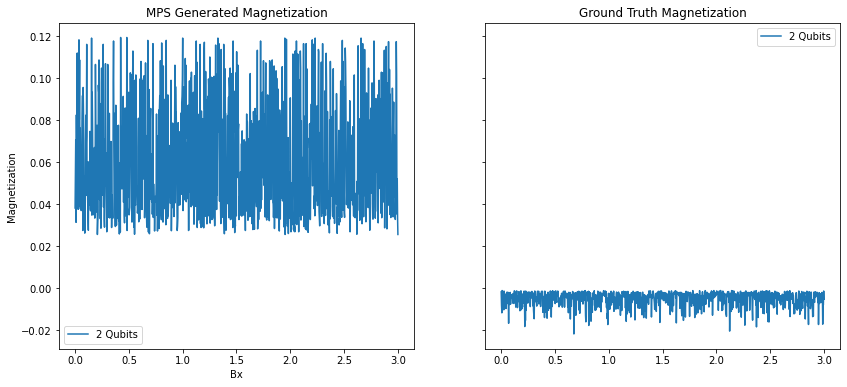

In [8]:
def seq_to_magnetization(arr_seq, num_qubits):
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits*num_qubits)
    return mag_vec   
    
data_set = {training_data}
mag_loaders = [DataLoader(x, batch_size = 1000, num_workers=6) for x in data_set]
data_sizes=[2]
model.eval()
with torch.no_grad():
    n_systems = {}
    for j,loader in enumerate((mag_loaders)):
        sys_size = data_sizes[j]
        wave_functions = []
        true_wave = []
        for i, (fields,wf) in enumerate(loader):
            fields = fields
            gs = model(fields, sys_size)

            wave_functions.append(gs)
            true_wave.append(wf)

            n_systems[sys_size] = (wave_functions,true_wave)


data_y_2 = n_systems[2][0][0].numpy()
    
print(data_y_2.shape)
data_y_2_t = n_systems[2][1][0].numpy()
    
vec = seq_to_magnetization(auto_encoder2d.seq_gen(2),2)
print(vec)
vec_2 = (vec.view()).reshape((16,1))
mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))
    
x = np.linspace(0,3,1000)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,6))
    
ax1.plot(x,mag_2, label='2 Qubits')

ax2.plot(x,mag_2_t, label='2 Qubits')



ax1.legend()
ax2.legend()
ax1.set_title("MPS Generated Magnetization")
ax2.set_title("Ground Truth Magnetization")
ax1.set_xlabel("Bx")
ax1.set_ylabel("Magnetization")
    #ax1.title('J=1, Bz=0.01')
    #ax1.set_xlabel("Bx")
    #ax1.set_ylabel("Magnetization")
    
    